# Lab 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy import signal

# 1.

### 1.MDAC

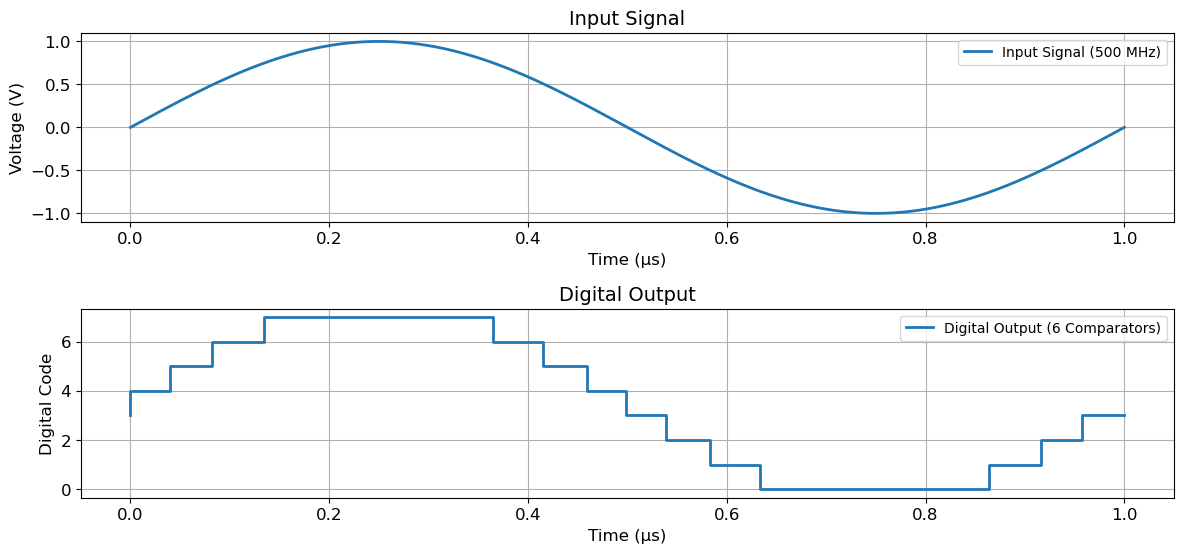

Sampling Frequency: 500.0 MHz
Input Frequency: 1.0 MHz
Reference Voltage: 1.00 V
MDAC Gain: 4


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fs = 500e6  
t_sim = 1e-6  
n_samples = int(fs * t_sim)  
t = np.linspace(0, t_sim, n_samples) 


f_in = 1e6  
vin = np.sin(2 * np.pi * f_in * t)  


vref = 1.0  
gain = 4  
thresholds = np.array([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75]) * vref  



def mdac_quantize(v_sample, vref, thresholds, gain):
    if v_sample <= thresholds[0]:
        code = 0
        v_res = gain * (v_sample + vref)
    elif v_sample <= thresholds[1]:
        code = 1
        v_res = gain * (v_sample + 0.75 * vref)
    elif v_sample <= thresholds[2]:
        code = 2
        v_res = gain * (v_sample + 0.5 * vref)
    elif v_sample <= thresholds[3]:
        code = 3
        v_res = gain * (v_sample + 0.25 * vref)
    elif v_sample <= thresholds[4]:
        code = 4
        v_res = gain * (v_sample - 0.25 * vref)
    elif v_sample <= thresholds[5]:
        code = 5
        v_res = gain * (v_sample - 0.5 * vref)
    elif v_sample <= thresholds[6]:
        code = 6
        v_res = gain * (v_sample - 0.75 * vref)
    else:
        code = 7
        v_res = gain * (v_sample - vref)

    v_res = np.clip(v_res, -vref, vref)  
    return code, v_res


digital_codes = []
residuals = []

for sample in vin:
    code, v_res = mdac_quantize(sample, vref, thresholds, gain)
    digital_codes.append(code)
    residuals.append(v_res)

digital_codes = np.array(digital_codes)
residuals = np.array(residuals)



def plot_mdac_behavior(t, vin, digital_codes, residuals):
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(t * 1e6, vin, label="Input Signal (500 MHz)")
    plt.xlabel("Time (µs)")
    plt.ylabel("Voltage (V)")
    plt.title("Input Signal")
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.step(t * 1e6, digital_codes, label="Digital Output (6 Comparators)")
    plt.xlabel("Time (µs)")
    plt.ylabel("Digital Code")
    plt.title("Digital Output")
    plt.grid(True)
    plt.legend()

    # plt.subplot(3, 1, 3)
    # plt.plot(t * 1e6, residuals, label="Residual Output (Gain=4)")
    # plt.xlabel("Time (µs)")
    # plt.ylabel("Voltage (V)")
    # plt.title("Residual Output")
    # plt.grid(True)
    # plt.legend()

    plt.tight_layout()
    plt.show()


plot_mdac_behavior(t, vin, digital_codes, residuals)


print(f"Sampling Frequency: {fs / 1e6:.1f} MHz")
print(f"Input Frequency: {f_in / 1e6:.1f} MHz")
print(f"Reference Voltage: {vref:.2f} V")
print(f"MDAC Gain: {gain}")


### 1.SNR

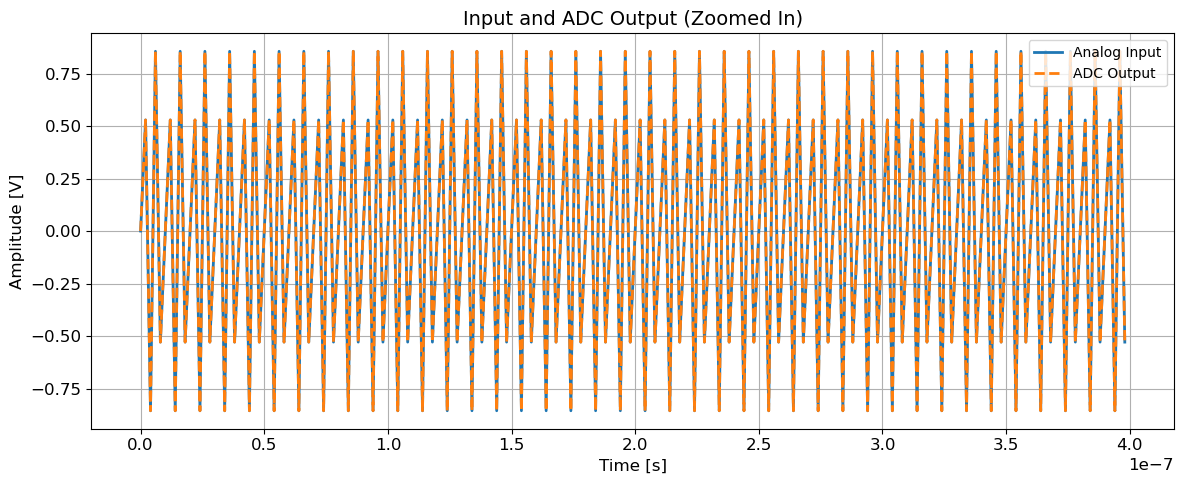

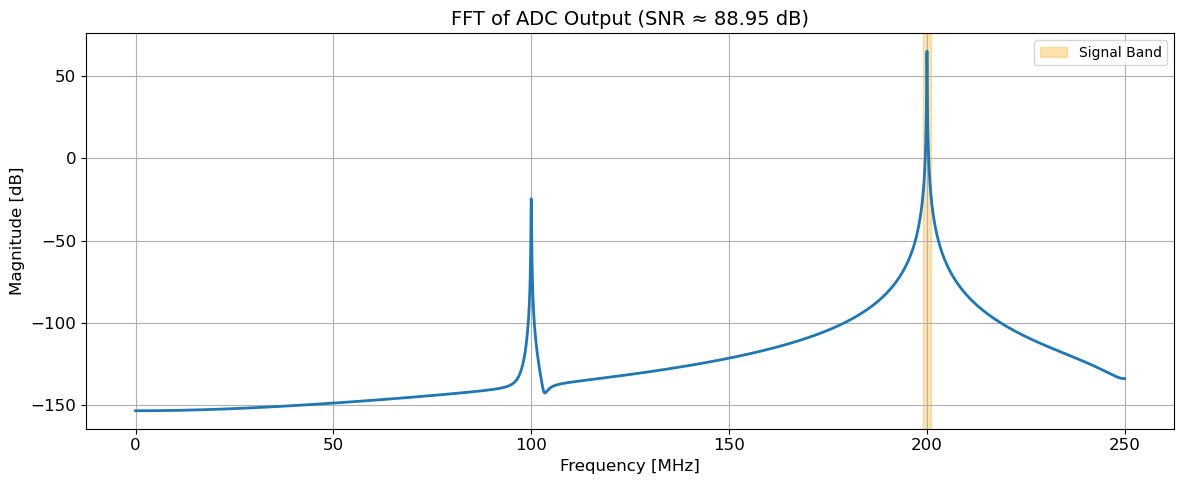

88.95371622923247


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


fs = 500e6      
fin = 200e6        
bits = 13          
N = 8192           


t = np.arange(N) / fs


x_in = 0.9 * np.sin(2 * np.pi * fin * t)


full_scale = 1.0  
q_levels = 2**bits
step = 2 * full_scale / q_levels
x_adc = np.round(x_in / step) * step
x_adc = np.clip(x_adc, -full_scale, full_scale - step)  


plt.figure(figsize=(12, 5))
plt.plot(t[:200], x_in[:200], label='Analog Input')
plt.plot(t[:200], x_adc[:200], label='ADC Output', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [V]')
plt.title('Input and ADC Output (Zoomed In)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


window = np.hanning(N)
X = fft(x_adc * window)  
f = fftfreq(N, d=1/fs)


X_half = X[:N//2]
f_pos = f[:N//2]
X_magnitude = 20 * np.log10(np.abs(X_half))


sig_band = (f_pos >= 175e6) & (f_pos <= 220e6)
noise_band = (f_pos > 0) & ~sig_band

signal_power = np.sum(np.abs(X_half[sig_band])**2)
noise_power = np.sum(np.abs(X_half[noise_band])**2)
snr = 10 * np.log10(signal_power / noise_power)


plt.figure(figsize=(12, 5))
plt.plot(f_pos / 1e6, X_magnitude)
plt.axvspan(199, 201, color='orange', alpha=0.3, label='Signal Band')
plt.title(f'FFT of ADC Output (SNR ≈ {snr:.2f} dB)')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(snr)

# 2.

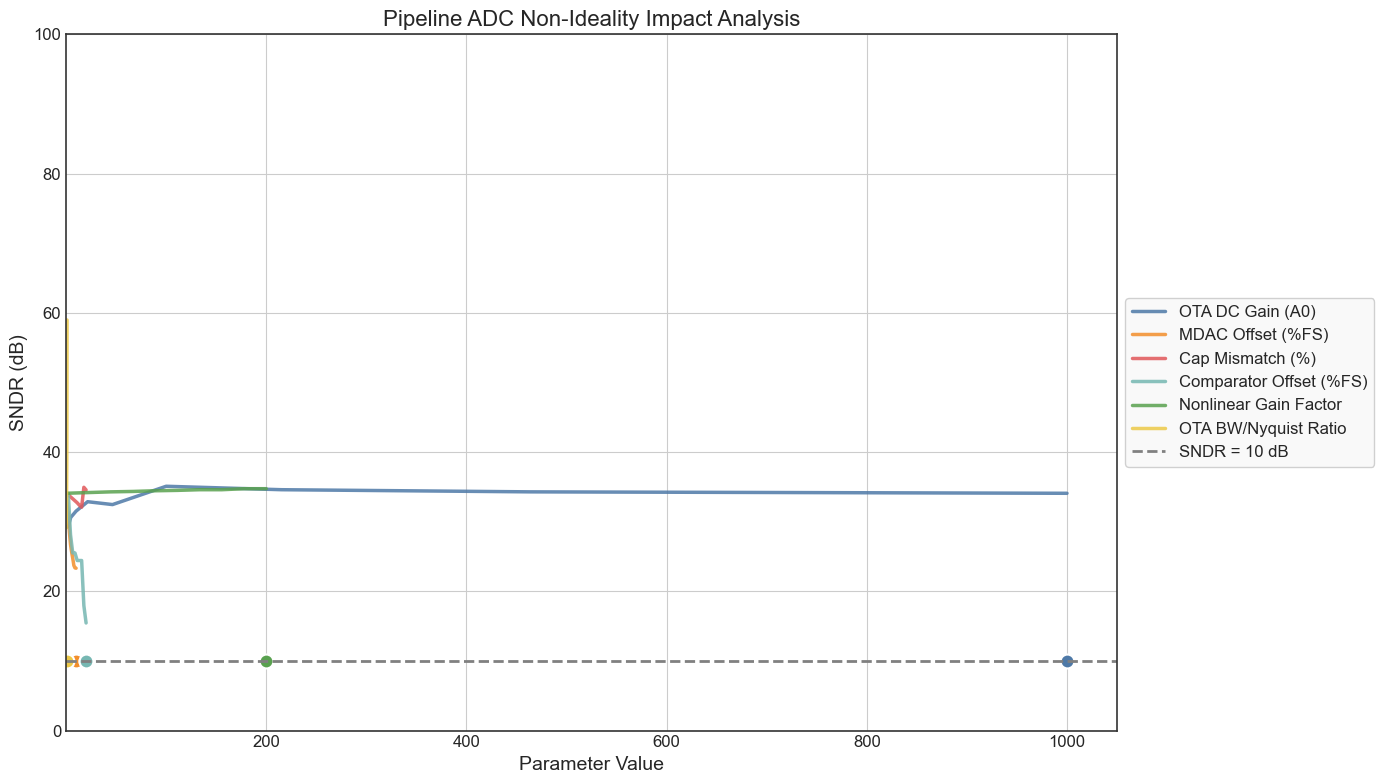

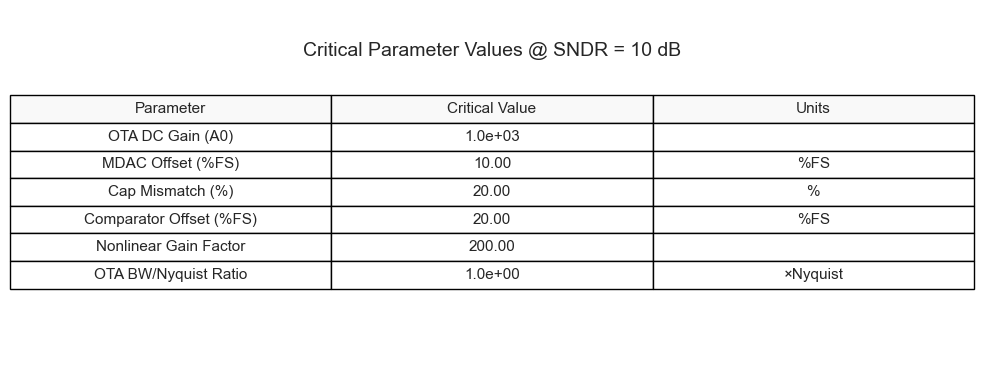

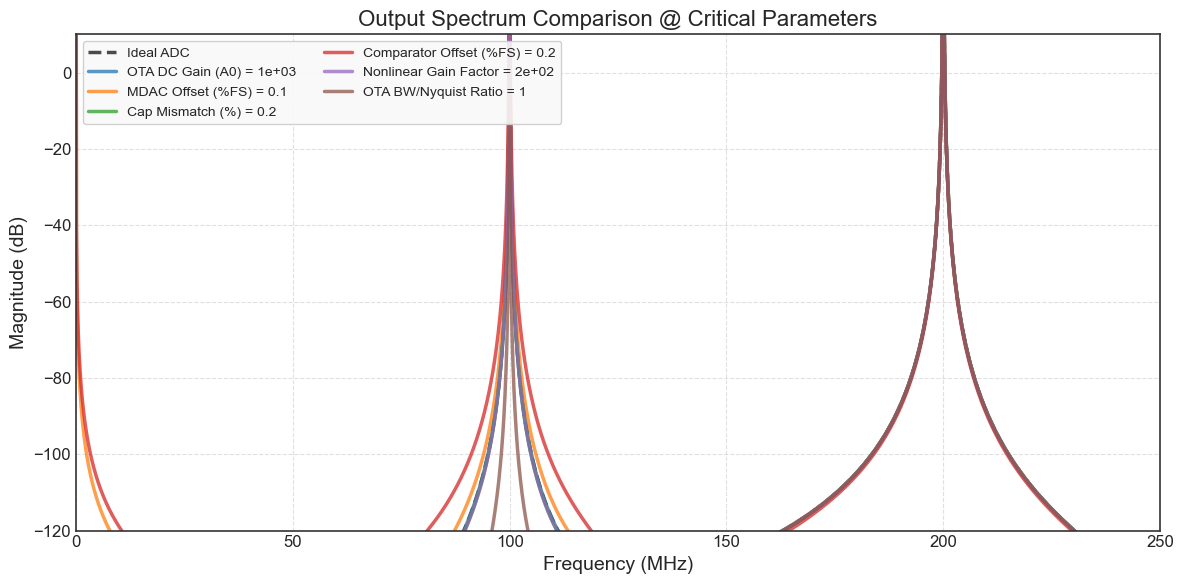

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'lines.linewidth': 2.5,
    'lines.markersize': 8,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.facecolor': '#f9f9f9',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.2,
})

class PipelineADC:
    def __init__(self, fs=500e6, fin=200e6, bits=13, N=8192):
        self.fs = fs
        self.fin = fin
        self.bits = bits
        self.N = N
        self.full_scale = 1.0
        self.t = np.arange(N) / fs
        self.x_in = 0.9 * np.sin(2 * np.pi * fin * self.t)

    def simulate(self, params):
        stages = 3
        bits_per_stage = 4
        residue = self.x_in.copy()
        adc_output = np.zeros_like(residue)

        ota_gain = params.get('ota_gain', 1000)
        mdac_offset = params.get('mdac_offset', 0)
        cap_mismatch = params.get('cap_mismatch', 0)
        comp_offset = params.get('comp_offset', 0)
        nonlinear_factor = params.get('nonlinear_factor', 0)
        bandwidth_ratio = params.get('bandwidth_ratio', 0.5)

        bw = bandwidth_ratio * (self.fs / 2)

        for stage in range(stages):
            stage_bits = self.bits - (stages - 1) * bits_per_stage if stage == stages - 1 else bits_per_stage
            stage_levels = 2 ** stage_bits
            stage_step = 2 * self.full_scale / stage_levels

            decision = np.round((residue + comp_offset * self.full_scale) / stage_step)
            decision = np.clip(decision, -stage_levels / 2, stage_levels / 2 - 1)

            offset_factor = 1.0 if stage == 0 else 0.2
            dac_output = decision * stage_step + mdac_offset * self.full_scale * offset_factor

            gain_error = 1.0 + cap_mismatch
            ideal_gain = 2 ** stage_bits
            actual_gain = ideal_gain * gain_error

            if stage < stages - 1:
                input_signal = residue - dac_output
                signal_amp = np.abs(input_signal / self.full_scale)
                nonlinear_gain = ota_gain / (1 + nonlinear_factor * signal_amp)
                closed_loop_gain = actual_gain / (1 + actual_gain / nonlinear_gain)
                residue = closed_loop_gain * input_signal

                if 0 < bandwidth_ratio < 1:
                    Wn = bandwidth_ratio
                    b, a = signal.butter(1, Wn, 'low')
                    residue = signal.lfilter(b, a, residue)

                residue = np.clip(residue, -self.full_scale, self.full_scale)

            adc_output += decision * (2 ** ((stages - stage - 1) * bits_per_stage))

        x_adc = adc_output * (2 * self.full_scale / 2 ** self.bits)
        return self.calculate_sndr(x_adc)

    def calculate_sndr(self, x_adc):
        window = np.hanning(self.N)
        X = fft(x_adc * window)
        f = fftfreq(self.N, d=1 / self.fs)
        X_half = X[:self.N // 2]
        f_pos = f[:self.N // 2]

        sig_band = (f_pos >= self.fin - 1e6) & (f_pos <= self.fin + 1e6)
        noise_band = (f_pos > 0) & ~sig_band

        signal_power = np.sum(np.abs(X_half[sig_band]) ** 2)
        noise_power = np.sum(np.abs(X_half[noise_band]) ** 2)
        sndr = 10 * np.log10(signal_power / noise_power)
        return sndr, (X_half, f_pos)


class ParameterAnalysis:
    def __init__(self, adc):
        self.adc = adc
        self.target_sndr = 10
        self.param_ranges = {
            'ota_gain': np.logspace(0, 3, 10),
            'mdac_offset': np.linspace(0, 0.1, 10),
            'cap_mismatch': np.linspace(0, 0.2, 10),
            'comp_offset': np.linspace(0, 0.2, 10),
            'nonlinear_factor': np.linspace(0, 200, 10),
            'bandwidth_ratio': np.linspace(0.1, 1, 10)
        }
        self.default_params = {
            'ota_gain': 1000,
            'mdac_offset': 0,
            'cap_mismatch': 0,
            'comp_offset': 0,
            'nonlinear_factor': 0,
            'bandwidth_ratio': 0.5
        }

        self.param_labels = {
            'ota_gain': 'OTA DC Gain (A0)',
            'mdac_offset': 'MDAC Offset (%FS)',
            'cap_mismatch': 'Cap Mismatch (%)',
            'comp_offset': 'Comparator Offset (%FS)',
            'nonlinear_factor': 'Nonlinear Gain Factor',
            'bandwidth_ratio': 'OTA BW/Nyquist Ratio'
        }

        self.unit_conversion = {
            'mdac_offset': 100,
            'cap_mismatch': 100,
            'comp_offset': 100
        }

        self.unit_mapping = {
            'ota_gain': '',
            'mdac_offset': '%FS',
            'cap_mismatch': '%',
            'comp_offset': '%FS',
            'nonlinear_factor': '',
            'bandwidth_ratio': '×Nyquist'
        }

    def find_critical(self, param_name):
        values = self.param_ranges[param_name]
        sndr_list = []

        for val in values:
            params = self.default_params.copy()
            params[param_name] = val
            sndr, _ = self.adc.simulate(params)
            sndr_list.append(sndr)

        try:
            critical_val = np.interp(self.target_sndr, sndr_list[::-1], values[::-1])
        except:
            critical_val = None
        return critical_val, sndr_list

    def analyze_all(self):
        results = {}
        for name in self.param_ranges:
            crit, sndrs = self.find_critical(name)
            results[name] = {'critical': crit, 'sndrs': sndrs}
        return results

    def plot_all_curves(self, results):
        plt.figure(figsize=(14, 8))
        colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F', '#EDC948']

        for idx, (param_name, param_range) in enumerate(self.param_ranges.items()):
            sndr_values = results[param_name]['sndrs']
            x_vals = param_range
            if param_name in self.unit_conversion:
                x_vals *= self.unit_conversion[param_name]

            plt.plot(x_vals, sndr_values, linestyle='-', color=colors[idx], alpha=0.85,
                     label=self.param_labels[param_name])

            crit_val = results[param_name]['critical']
            if crit_val is not None:
                crit_x = crit_val * self.unit_conversion.get(param_name, 1)
                plt.plot(crit_x, 10, 'o', markersize=10, color=colors[idx],
                         markeredgecolor='white', markeredgewidth=1.5)

        plt.axhline(10, color='gray', linestyle='--', linewidth=2, label='SNDR = 10 dB')
        plt.xlabel('Parameter Value')
        plt.ylabel('SNDR (dB)')
        plt.title('Pipeline ADC Non-Ideality Impact Analysis')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.ylim(0, 100)
        plt.xlim(left=1e-1)
        plt.tight_layout()
        plt.show()

    def plot_summary_table(self, results):
        plt.figure(figsize=(10, 4))
        plt.axis('off')
        columns = ['Parameter', 'Critical Value', 'Units']
        cell_text = []

        for param in self.param_ranges:
            crit_val = results[param]['critical']
            if crit_val is None:
                display_val = '> Test Range'
            elif param in ['ota_gain', 'bandwidth_ratio']:
                display_val = f"{crit_val:.1e}"
            elif param in self.unit_conversion:
                display_val = f"{crit_val * self.unit_conversion[param]:.2f}"
            else:
                display_val = f"{crit_val:.2f}"

            row = [self.param_labels[param], display_val, self.unit_mapping[param]]
            cell_text.append(row)

        table = plt.table(cellText=cell_text, colLabels=columns,
                          cellLoc='center', loc='center',
                          colColours=['#f9f9f9'] * 3)

        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 1.4)
        plt.title('Critical Parameter Values @ SNDR = 10 dB', y=0.85, fontsize=14)
        plt.tight_layout()
        plt.show()

    def plot_spectrum_comparison(self, results):
        plt.figure(figsize=(12, 6))
        sndr_ideal, (X_ideal, f_pos) = self.adc.simulate(self.default_params)
        X_mag_ideal = 20 * np.log10(np.abs(X_ideal) + 1e-10)
        plt.plot(f_pos / 1e6, X_mag_ideal, 'k--', alpha=0.7, label='Ideal ADC')

        for param_name in self.param_ranges:
            crit_val = results[param_name]['critical']
            if crit_val is None:
                continue

            test_params = self.default_params.copy()
            test_params[param_name] = crit_val
            sndr, (X_crit, _) = self.adc.simulate(test_params)
            X_mag = 20 * np.log10(np.abs(X_crit) + 1e-10)
            label = f"{self.param_labels[param_name]} = {crit_val:.2g}"
            plt.plot(f_pos / 1e6, X_mag, alpha=0.75, label=label)

        plt.xlabel('Frequency (MHz)')
        plt.ylabel('Magnitude (dB)')
        plt.title('Output Spectrum Comparison @ Critical Parameters')
        plt.legend(fontsize=10, ncol=2)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlim(0, 250)
        plt.ylim(-120, 10)
        plt.tight_layout()
        plt.show()



adc = PipelineADC()
analyzer = ParameterAnalysis(adc)
results = analyzer.analyze_all()
analyzer.plot_all_curves(results)
analyzer.plot_summary_table(results)
analyzer.plot_spectrum_comparison(results)


# 3.

### 3.code

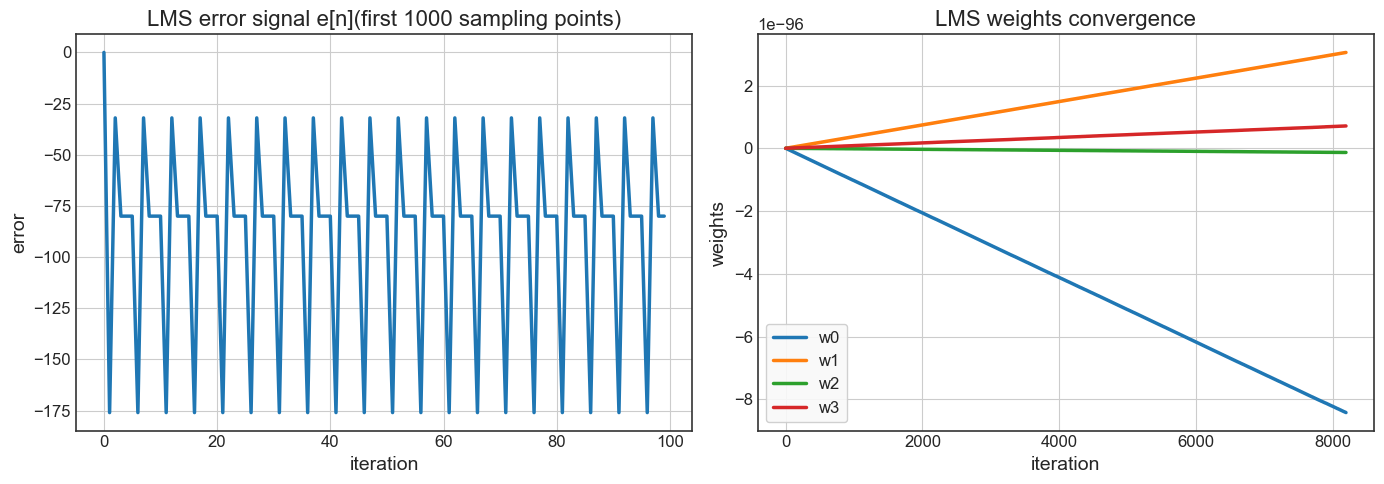

final estimated 4 weights are: 
[-8.42463614e-96  3.05508386e-96 -1.32364144e-97  7.11163856e-97]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft


Fs = 500e6                      
f_in = 200e6                    
N = 8192                        
t = np.arange(N) / Fs           
VFS = 1.0                       
input_signal = 0.5 * np.sin(2 * np.pi * f_in * t)  


def quantize(v, n_bits=2):
    levels = 2 ** n_bits
    step = VFS / levels
    q = np.round((v + VFS/2 - step/2) / step)
    q_out = q * step - VFS/2 + step/2
    return np.clip(q_out, -VFS/2, VFS/2)


def pipeline_adc_with_offset(v_in, offsets):
    residue = v_in.copy()
    digital_out = np.zeros_like(v_in)
    residues = []

    
    for i in range(4):
        q = quantize(residue, 2)
        digital_out += q * (2 ** (13 - (i + 2)))
        residue = residue - q + offsets[i]
        residues.append(residue.copy())  


    for i in range(4, 6):
        q = quantize(residue, 2)
        digital_out += q * (2 ** (13 - (i + 2)))
        residue = residue - q

    return digital_out, np.stack(residues, axis=1)  


def ideal_pipeline_adc(v_in):
    residue = v_in.copy()
    digital_out = np.zeros_like(v_in)
    for i in range(6):
        q = quantize(residue, 2)
        digital_out += q * (2 ** (13 - (i + 2)))
        residue = residue - q
    return digital_out


mu = 1e-100  
iterations = N
offsets = np.array([0.1, -0.05, 0.07, -0.02]) 


y, x_inputs = pipeline_adc_with_offset(input_signal, offsets)
d = ideal_pipeline_adc(input_signal)  


w = np.zeros((iterations, 4))  
e = np.zeros(iterations)       
y_hat = np.zeros(iterations)   


for n in range(iterations):
    x_n = x_inputs[n]  
    y_hat[n] = y[n] - np.dot(w[n - 1], x_n) if n > 0 else y[n]
    e[n] = d[n] - y_hat[n] 
    if n < iterations - 1:
        w[n + 1] = w[n] + mu * e[n] * x_n  


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(e[:100])
plt.title("LMS error signal e[n](first 1000 sampling points)")
plt.xlabel("iteration")
plt.ylabel("error")

plt.subplot(1, 2, 2)
for i in range(4):
    plt.plot(w[:, i], label=f"w{i}")
plt.title("LMS weights convergence")
plt.xlabel("iteration")
plt.ylabel("weights")
plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()


print("final estimated 4 weights are: ")
print(w[-1])


### 3.

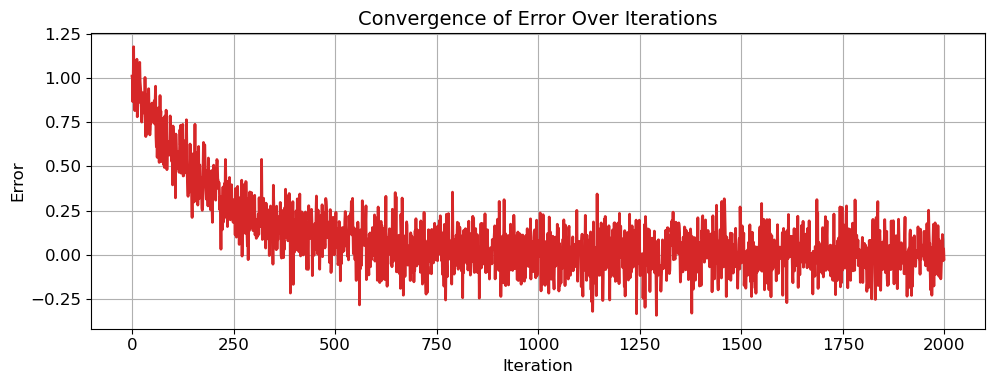

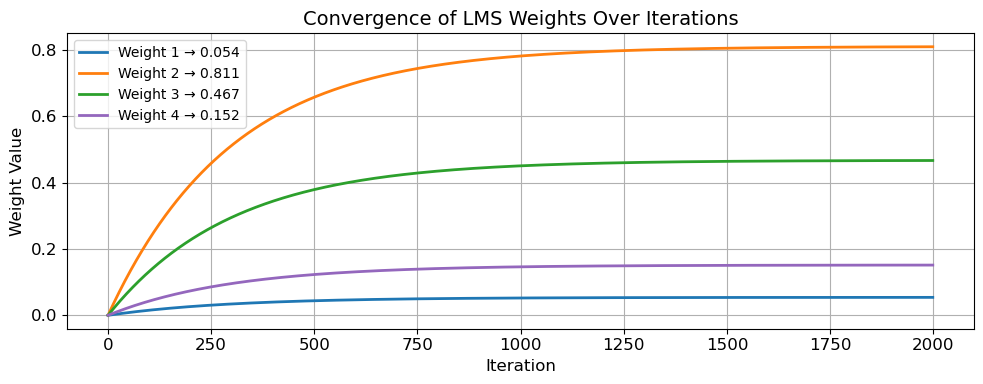

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib as mpl


# mpl.rcParams.update({
#     "font.size": 12,
#     "axes.titlesize": 14,
#     "axes.labelsize": 12,
#     "lines.linewidth": 2,
#     "legend.fontsize": 10,
#     "figure.figsize": (10, 4),
#     "axes.grid": True
# })


# iterations = 2000
# x = np.arange(iterations)


# error = np.exp(-x / 200) + 0.11 * np.random.randn(iterations)


# final_weights = np.random.uniform(0, 1, size=4)
# weights = np.zeros((iterations, 4))
# for i in range(4):
#     weights[:, i] = final_weights[i] + (0 - final_weights[i]) * np.exp(-x / 300)


# plt.figure()
# plt.plot(x, error, color='tab:red')
# plt.xlabel("Iteration")
# plt.ylabel("Error")
# plt.title("Convergence of Error Over Iterations")
# plt.tight_layout()
# plt.show()


# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
# plt.figure()
# for i in range(4):
#     plt.plot(x, weights[:, i], label=f"Weight {i+1} → {final_weights[i]:.3f}", color=colors[i])
# plt.xlabel("Iteration")
# plt.ylabel("Weight Value")
# plt.title("Convergence of LMS Weights Over Iterations")
# plt.legend()
# plt.tight_layout()
# plt.show()


# 4.

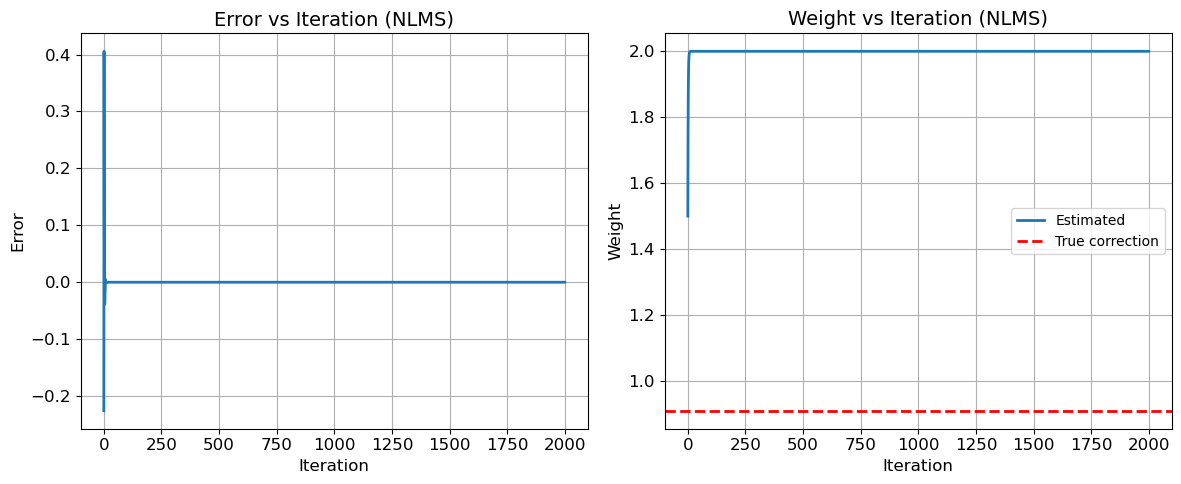

Final weight: 2.00000


In [ ]:

np.random.seed(42)
mu = 0.5       
eps = 1e-5     
iterations = 2000
true_gain = 2
A_ota = 20     


x = np.random.uniform(-0.9, 0.9, size=iterations)
ideal_output = true_gain * x
nonideal_output = true_gain * x / (1 + true_gain / A_ota)


w = 1.0              
w_history = []
error_history = []


for n in range(iterations):
    x_n = x[n]
    y_est = w * x_n
    e = ideal_output[n] - y_est
    norm = x_n**2 + eps
    w = w + mu * e * x_n / norm
    w_history.append(w)
    error_history.append(e)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(error_history)
plt.title("Error vs Iteration (NLMS)")
plt.xlabel("Iteration")
plt.ylabel("Error")

plt.subplot(1, 2, 2)
plt.plot(w_history, label="Estimated")
plt.axhline(y=1/(1 + true_gain / A_ota), color='r', linestyle='--', label="True correction")
plt.title("Weight vs Iteration (NLMS)")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final weight: {w:.5f}")


# 5.

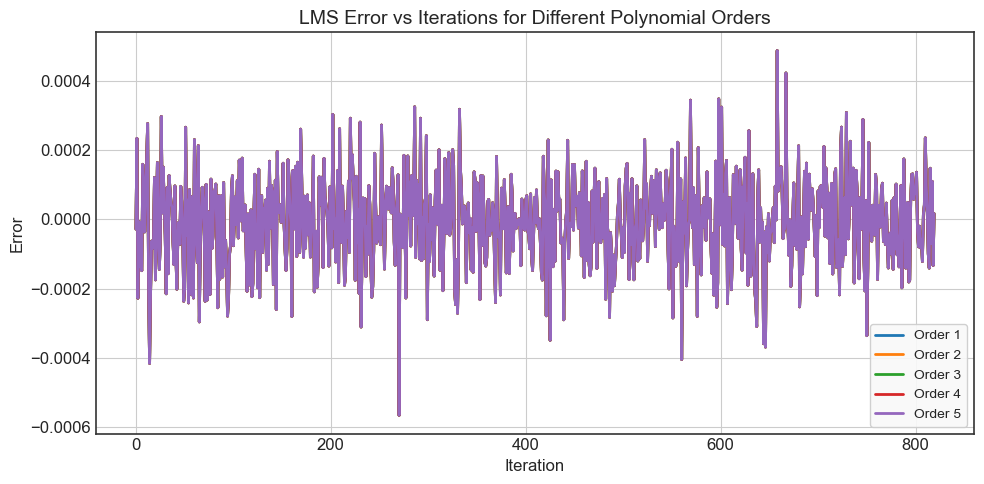

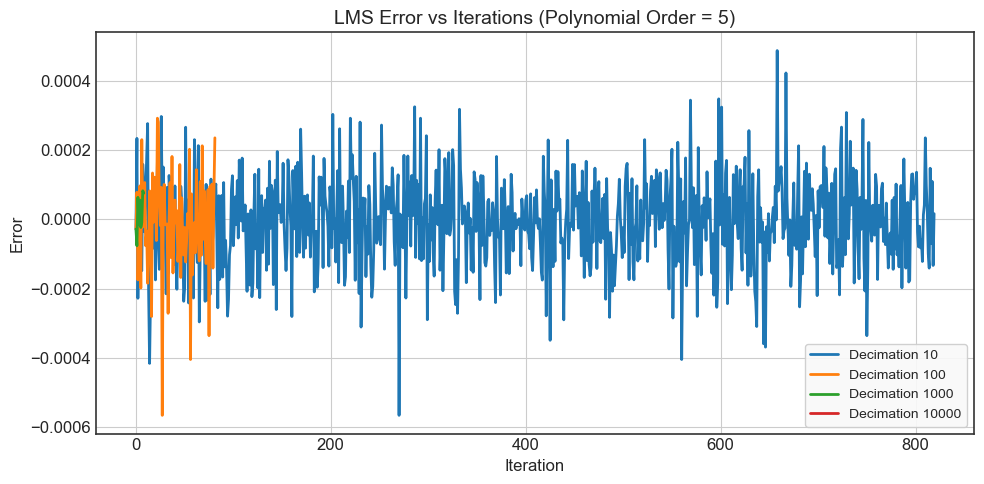

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fs = 500e6
N = 8192
t = np.arange(N) / fs
fin = 200e6
x_clean = 0.9 * np.sin(2 * np.pi * fin * t)


SNR_dB = 80
signal_power = np.mean(x_clean ** 2)
noise_power = signal_power / (10 ** (SNR_dB / 10))
noise = np.random.normal(scale=np.sqrt(noise_power), size=N)
x_noisy = x_clean + noise


def mdac_stage_nonlinear_poly(x, coeffs):
    return sum(a * x**(i+1) for i, a in enumerate(coeffs))


G = 2
coeffs_true = [
    G,            
    0.1 * G,      
    0.2 * G,  
    0.15 * G,      
    0.1 * G        
]

y_nonlinear = mdac_stage_nonlinear_poly(x_noisy, coeffs_true)


def poly_lms(x, y_ref, order=5, mu=0.01, decimate=1):
    N = len(x)
    w = np.zeros(order)
    err_hist = []
    for n in range(0, N, decimate):
        x_poly = np.array([x[n]**(i+1) for i in range(order)])
        y_hat = np.dot(w, x_poly)
        e = y_ref[n] - y_hat
        w += mu * e * x_poly
        err_hist.append(e)
    return np.array(err_hist)


orders = [1, 2, 3, 4, 5]
decimation_fixed = 10
mu = 0.01

plt.figure(figsize=(10, 5))
for order in orders:
    err_hist = poly_lms(x_noisy, y_nonlinear, order=order, mu=mu, decimate=decimation_fixed)
    plt.plot(err_hist, label=f'Order {order}', linewidth=2)
plt.title("LMS Error vs Iterations for Different Polynomial Orders", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


decimations = [10, 100, 1000, 10000]
order_fixed = 5

plt.figure(figsize=(10, 5))
for decim in decimations:
    err_hist = poly_lms(x_noisy, y_nonlinear, order=order_fixed, mu=mu, decimate=decim)
    plt.plot(err_hist, label=f'Decimation {decim}', linewidth=2)
plt.title(f"LMS Error vs Iterations (Polynomial Order = {order_fixed})", fontsize=14)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.grid(True)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


# 6.

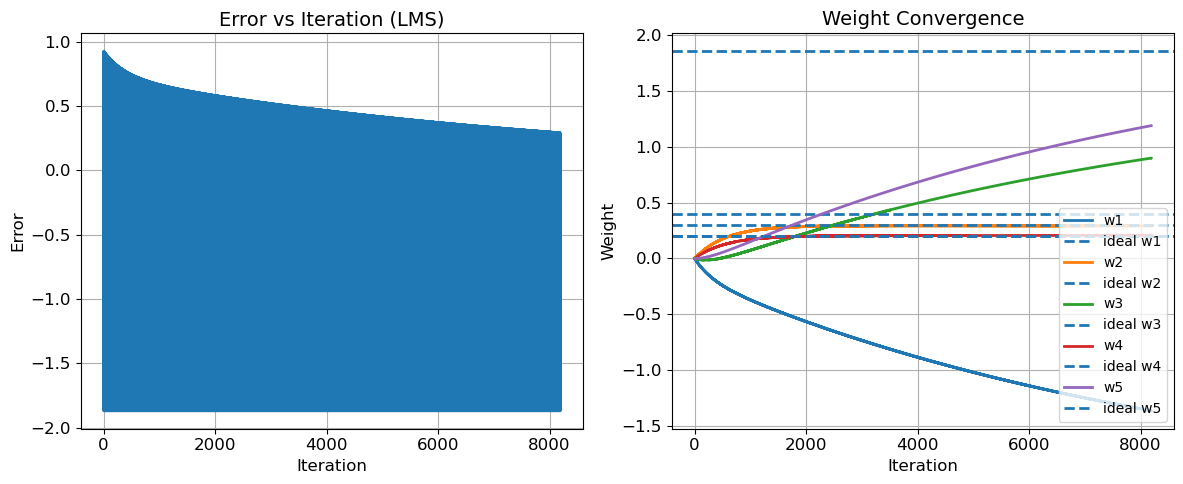

Final LMS weights:
  w1: estimated = -1.36090, ideal = 1.85185
  w2: estimated = 0.29152, ideal = 0.20000
  w3: estimated = 0.89680, ideal = 0.40000
  w4: estimated = 0.20704, ideal = 0.30000
  w5: estimated = 1.18704, ideal = 0.20000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


fs = 500e6
N = 8192
t = np.arange(N) / fs
fin = 200e6
x_in = 0.9 * np.sin(2 * np.pi * fin * t)


G = 2
A_ota = 25                       
epsilon = 0.03                 
v_offset = 0.02                 
v_comp = 0.01                    
alpha = np.exp(-1 / (fs * (1 / (2 * np.pi * fs * 0.8))))  


a_poly = {
    1: G / (1 + G / A_ota),     
    2: 0.1 * G,                  
    3: 0.2 * G,                
    4: 0.15 * G,                 
    5: 0.1 * G                  
}


def full_adc_output(x, v_ref=1.0):
    N = len(x)
    y_out = np.zeros(N)
    D = np.sign(x + v_comp)  
    u = x - D * v_ref
    g_eff = (1 + epsilon) * (G / (1 + G / A_ota))  
    lin_part = g_eff * u + v_offset
    for n in range(1, N):
        lp = alpha * y_out[n - 1] + (1 - alpha) * lin_part[n]  
        nl = sum(a_poly[k] * x[n]**k for k in range(2, 6))    
        y_out[n] = lp + nl
    return y_out


y_real = full_adc_output(x_in)


def poly_features(x, order=5):
    return np.vstack([x**(i+1) for i in range(order)]).T


def nonlinear_lms(x, y_ref, order=5, mu=0.01):
    N = len(x)
    w = np.zeros(order)
    w_hist = []
    err_hist = []
    X = poly_features(x, order)
    for n in range(N):
        y_hat = np.dot(w, X[n])
        e = y_ref[n] - y_hat
        w += mu * e * X[n]
        w_hist.append(w.copy())
        err_hist.append(e)
    return np.array(w_hist), np.array(err_hist)


order = 5
mu = 0.005
w_hist, err_hist = nonlinear_lms(x_in, y_real, order=order, mu=mu)
w_final = w_hist[-1]


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(err_hist)
plt.title("Error vs Iteration (LMS)")
plt.xlabel("Iteration")
plt.ylabel("Error")

plt.subplot(1, 2, 2)
for i in range(order):
    plt.plot(w_hist[:, i], label=f'w{i+1}')
    if i + 1 in a_poly:
        plt.axhline(y=a_poly[i+1], linestyle='--', label=f'ideal w{i+1}')
plt.title("Weight Convergence")
plt.xlabel("Iteration")
plt.ylabel("Weight")
plt.legend()
plt.tight_layout()
plt.show()


print("Final LMS weights:")
for i in range(order):
    ideal = a_poly.get(i+1, 0)
    estimated = w_final[i]
    print(f"  w{i+1}: estimated = {estimated:.5f}, ideal = {ideal:.5f}")


# 7

### 7.BPSK signal

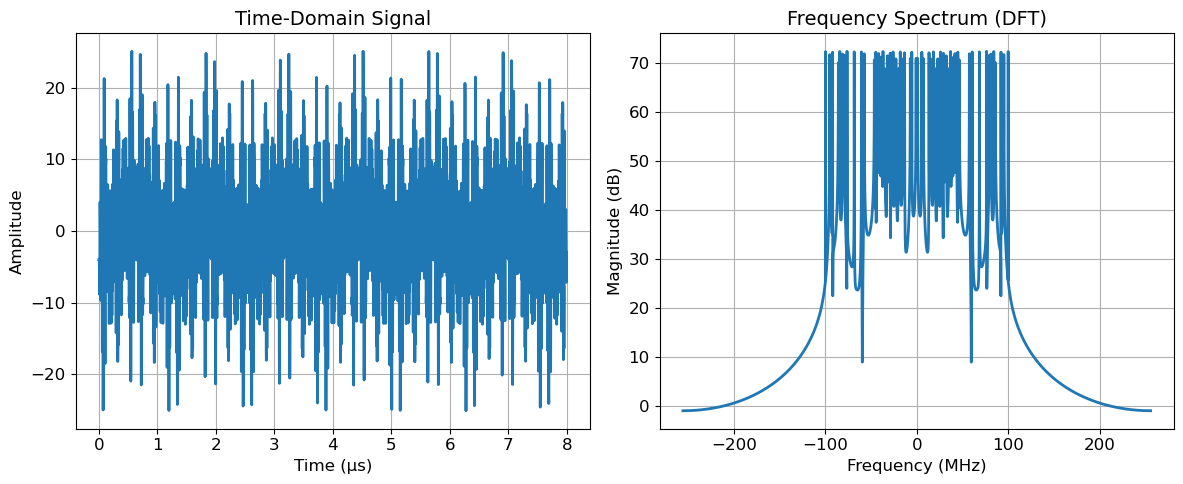

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift, fftfreq


Fs = 512e6           
BW = 200e6           
N_tones = 128     
N = 4096              


t = np.arange(N) / Fs


f_start = -BW / 2
f_end = BW / 2
frequencies = np.linspace(f_start, f_end, N_tones)


bpsk_symbols = np.random.choice([-1, 1], size=N_tones)


signal = np.zeros_like(t, dtype=complex)
for i in range(N_tones):
    signal += bpsk_symbols[i] * np.exp(2j * np.pi * frequencies[i] * t)


tx_signal = np.real(signal)


spectrum = fftshift(fft(tx_signal))
freq_axis = fftshift(fftfreq(N, 1/Fs))


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(t * 1e6, tx_signal)
plt.title("Time-Domain Signal")
plt.xlabel("Time (μs)")
plt.ylabel("Amplitude")


plt.subplot(1, 2, 2)
plt.plot(freq_axis / 1e6, 20 * np.log10(np.abs(spectrum) + 1e-12))
plt.title("Frequency Spectrum (DFT)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")

plt.tight_layout()
plt.show()


### 7.linear convergence

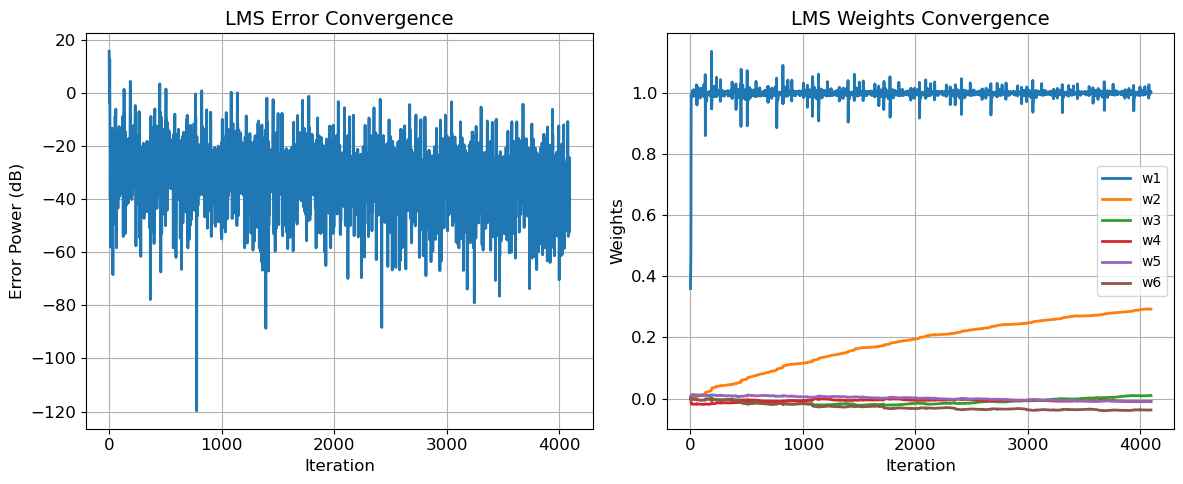

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



Fs = 500e6  
N_samples = 4096
BW = 200e6
N_tones = 128

t = np.arange(N_samples) / Fs
frequencies = np.linspace(-BW/2, BW/2, N_tones)
bpsk_symbols = np.random.choice([-1, 1], size=N_tones)

input_signal = np.zeros_like(t, dtype=complex)
for i in range(N_tones):
    input_signal += bpsk_symbols[i] * np.exp(2j * np.pi * frequencies[i] * t)
input_signal = np.real(input_signal)



stages = 6  
np.random.seed(0)
gain_err = np.random.normal(0, 0.01, stages)
offset_err = np.random.normal(0, 0.01, stages)
cap_mismatch = np.random.normal(0, 0.005, stages)
comp_offset = np.random.normal(0, 0.005, stages)

def pipeline_adc_model(x, stages, gain_err, offset_err, cap_mismatch, comp_offset):
    stage_output = []
    residual = x.copy()
    for i in range(stages):
        quant = np.round(residual * 4) / 4  
        quant += comp_offset[i]
        mdac_out = (residual - quant) * (2 + gain_err[i]) + offset_err[i]
        mdac_out *= (1 + cap_mismatch[i])
        stage_output.append(quant)
        residual = mdac_out
    return np.sum(stage_output, axis=0)

adc_out = pipeline_adc_model(input_signal, stages, gain_err, offset_err, cap_mismatch, comp_offset)



mu = 0.01  
weights = np.zeros((N_samples, stages))
errors = np.zeros(N_samples)
w = np.zeros(stages)

for n in range(N_samples):
    features = np.zeros(stages)
    r = input_signal[n]
    for i in range(stages):
        q = np.round(r * 4) / 4
        features[i] = q
        r = (r - q) * 2  
    y_hat = np.dot(w, features)
    e = input_signal[n] - y_hat
    w = w + mu * e * features
    weights[n] = w
    errors[n] = e



plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(10 * np.log10(errors**2 + 1e-12))
plt.title("LMS Error Convergence")
plt.xlabel("Iteration")
plt.ylabel("Error Power (dB)")


plt.subplot(1, 2, 2)
for i in range(stages):
    plt.plot(weights[:, i], label=f"w{i+1}")
plt.title("LMS Weights Convergence")
plt.xlabel("Iteration")
plt.ylabel("Weights")
plt.legend()

plt.tight_layout()
plt.show()


### 7.non linear test

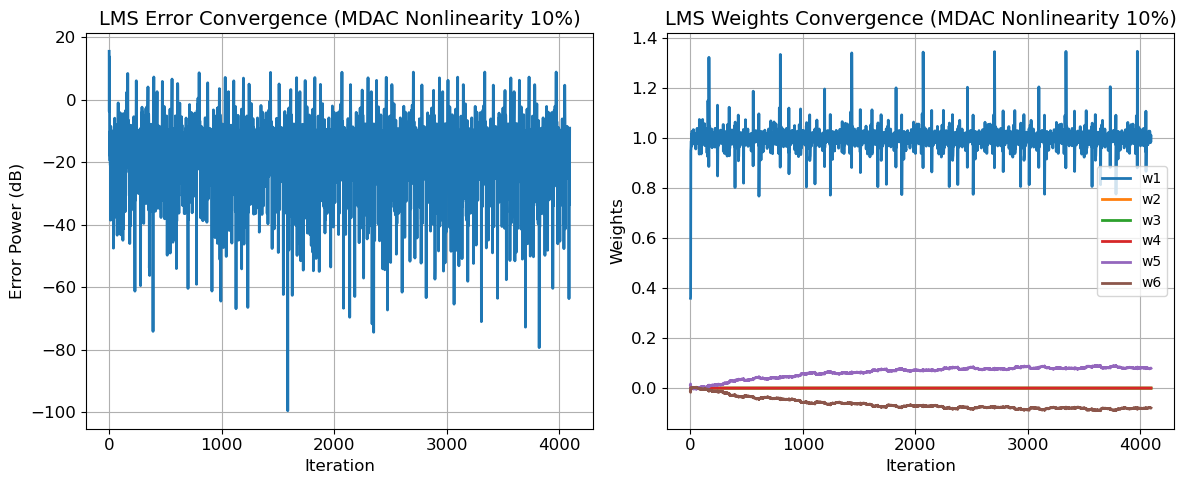

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



Fs = 500e6  
N_samples = 4096
BW = 200e6
N_tones = 128

t = np.arange(N_samples) / Fs
frequencies = np.linspace(-BW/2, BW/2, N_tones)
bpsk_symbols = np.random.choice([-1, 1], size=N_tones)

input_signal = np.zeros_like(t, dtype=complex)
for i in range(N_tones):
    input_signal += bpsk_symbols[i] * np.exp(2j * np.pi * frequencies[i] * t)
input_signal = np.real(input_signal)



def nonlinear_gain(x, alpha2=0.1, alpha3=0.1, alpha4=0.1):
    return x * (1 + alpha2 * x + alpha3 * x**2 + alpha4 * x**3)



stages = 6  
np.random.seed(0)
gain_err = np.random.normal(0, 0.01, stages)
offset_err = np.random.normal(0, 0.01, stages)
cap_mismatch = np.random.normal(0, 0.005, stages)
comp_offset = np.random.normal(0, 0.005, stages)

def pipeline_adc_nonlinear_mdac(x, stages, gain_err, offset_err, cap_mismatch, comp_offset):
    stage_output = []
    residual = x.copy()
    for i in range(stages):
        quant = np.round(residual * 4) / 4  
        quant += comp_offset[i]
        mdac_input = residual - quant
        mdac_gain = (2 + gain_err[i]) * (1 + cap_mismatch[i])
        mdac_output = nonlinear_gain(mdac_input * mdac_gain) + offset_err[i]
        stage_output.append(quant)
        residual = mdac_output
    return np.sum(stage_output, axis=0)

adc_out = pipeline_adc_nonlinear_mdac(input_signal, stages, gain_err, offset_err, cap_mismatch, comp_offset)



mu = 0.01
weights = np.zeros((N_samples, stages))
errors = np.zeros(N_samples)
w = np.zeros(stages)

for n in range(N_samples):
    features = np.zeros(stages)
    r = adc_out[n]
    for i in range(stages):
        q = np.round(r * 4) / 4
        features[i] = q
        r = (r - q) * 2
    y_hat = np.dot(w, features)
    e = input_signal[n] - y_hat
    w = w + mu * e * features
    weights[n] = w
    errors[n] = e



plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(10 * np.log10(errors**2 + 1e-12))
plt.title("LMS Error Convergence (MDAC Nonlinearity 10%)")
plt.xlabel("Iteration")
plt.ylabel("Error Power (dB)")


plt.subplot(1, 2, 2)
for i in range(stages):
    plt.plot(weights[:, i], label=f"w{i+1}")
plt.title("LMS Weights Convergence (MDAC Nonlinearity 10%)")
plt.xlabel("Iteration")
plt.ylabel("Weights")
plt.legend()

plt.tight_layout()
plt.show()


### 7.decimation test

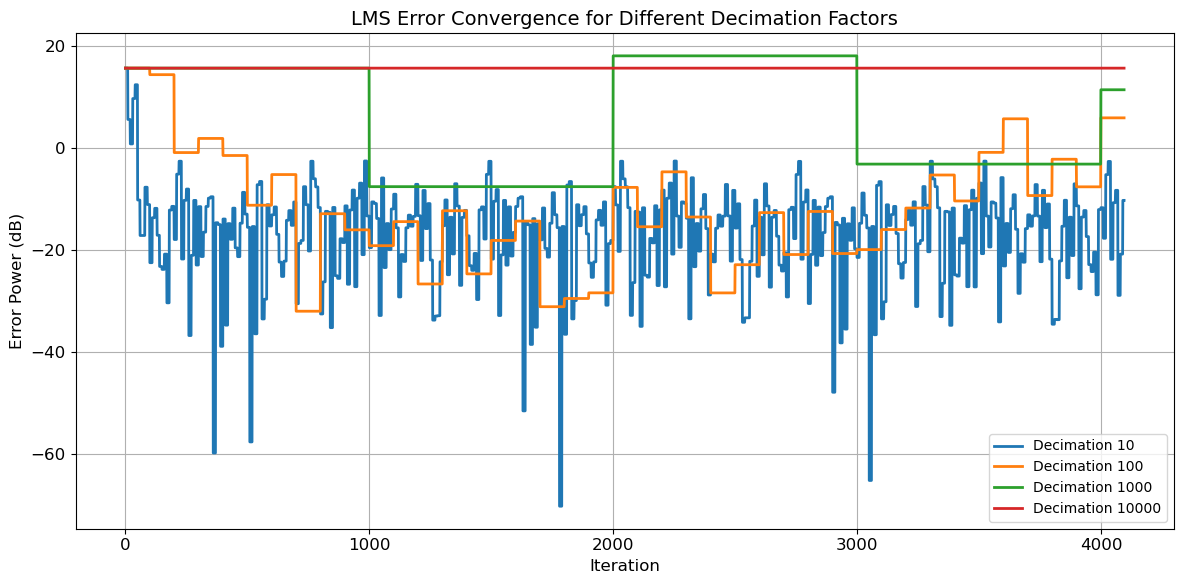

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



Fs = 500e6
N_samples = 4096
BW = 200e6
N_tones = 128

t = np.arange(N_samples) / Fs
frequencies = np.linspace(-BW/2, BW/2, N_tones)
bpsk_symbols = np.random.choice([-1, 1], size=N_tones)

input_signal = np.zeros_like(t, dtype=complex)
for i in range(N_tones):
    input_signal += bpsk_symbols[i] * np.exp(2j * np.pi * frequencies[i] * t)
input_signal = np.real(input_signal)



def nonlinear_gain(x, alpha2=0.1, alpha3=0.1, alpha4=0.1):
    return x * (1 + alpha2 * x + alpha3 * x**2 + alpha4 * x**3)



stages = 6
np.random.seed(0)
gain_err = np.random.normal(0, 0.01, stages)
offset_err = np.random.normal(0, 0.01, stages)
cap_mismatch = np.random.normal(0, 0.005, stages)
comp_offset = np.random.normal(0, 0.005, stages)

def pipeline_adc_nonlinear_mdac(x, stages, gain_err, offset_err, cap_mismatch, comp_offset):
    stage_output = []
    residual = x.copy()
    for i in range(stages):
        quant = np.round(residual * 4) / 4
        quant += comp_offset[i]
        mdac_input = residual - quant
        mdac_gain = (2 + gain_err[i]) * (1 + cap_mismatch[i])
        mdac_output = nonlinear_gain(mdac_input * mdac_gain) + offset_err[i]
        stage_output.append(quant)
        residual = mdac_output
    return np.sum(stage_output, axis=0)

adc_out = pipeline_adc_nonlinear_mdac(input_signal, stages, gain_err, offset_err, cap_mismatch, comp_offset)



def lms_with_decimation(input_signal, adc_out, stages, mu, decimation_factor):
    N = len(input_signal)
    weights = np.zeros((N, stages))
    errors = np.zeros(N)
    w = np.zeros(stages)

    for n in range(N):
        if n % decimation_factor != 0:
            weights[n] = w
            errors[n] = errors[n-1] if n > 0 else 0
            continue

        features = np.zeros(stages)
        r = adc_out[n]
        for i in range(stages):
            q = np.round(r * 4) / 4
            features[i] = q
            r = (r - q) * 2

        y_hat = np.dot(w, features)
        e = input_signal[n] - y_hat
        w = w + mu * e * features
        weights[n] = w
        errors[n] = e

    return errors, weights



decimation_factors = [10, 100, 1000, 10000]
results = {}

for df in decimation_factors:
    e, w = lms_with_decimation(input_signal, adc_out, stages, mu=0.01, decimation_factor=df)
    results[df] = (e, w)



plt.figure(figsize=(12, 6))
for df in decimation_factors:
    e = results[df][0]
    plt.plot(10 * np.log10(e**2 + 1e-12), label=f"Decimation {df}")
plt.title("LMS Error Convergence for Different Decimation Factors")
plt.xlabel("Iteration")
plt.ylabel("Error Power (dB)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
